# Puzzle Framework Demonstration
## Distillation-Based NAS for Inference-Optimized LLMs

This notebook demonstrates the **Puzzle framework** from the [ICML 2025 paper](https://openreview.net/pdf?id=RY5MMBHRqo), focusing on the Mixed-Integer Programming (MIP) optimization stage that selects optimal block configurations for efficient LLM inference.

### Overview of the Puzzle Framework

The Puzzle framework consists of three main stages:
1. **Block Library Construction**: Train alternative block variants for each layer in parallel with Blockwise Local Distillation (BLD).
2. **MIP-based Architecture Search**: Find optimal configuration satisfying hardware constraints (this notebook).
3. **Global Knowledge Distillation (GKD)**: Fine-tune the reassembled model.

This demonstration focuses on Stage 2, where we use Mixed-Integer Programming to search through billions of possible architectures to find the optimal trade-off between model accuracy and inference efficiency.


In [1]:
import sys
sys.path.append("..")  # Add parent directory to path to find the puzzle module

from puzzle.mip_nas import mip_nas, multi_solution_mip_nas
from utils import load_and_display_data, display_solution_stats, visualize_runtime_reduction, comprehensive_solution_comparison


## Understanding the MIP Formulation

### The Optimization Problem

For a model with $L$ layers, where each layer $i$ has $K_i$ possible block variants, the MIP solver finds:

$\text{maximize/minimize } \sum_{i=1}^{L} \sum_{j=1}^{K_i} \text{score}(i,j) \cdot x_{i,j}$

Subject to:
- **Uniqueness constraint**: $\sum_{j=1}^{K_i} x_{i,j} = 1$ for each layer $i$ (exactly one variant per layer).
- **Resource constraints**: $\sum_{i=1}^{L} \sum_{j=1}^{K_i} \text{cost}(i,j)^{(m)} \cdot x_{i,j} \leq C_m$ for each constraint $m$.

Where:
- $x_{i,j} \in \{0, 1\}$ indicates whether block variant $j$ is chosen for layer $i$.
- $\text{score}(i,j)$ is the objective metric (e.g., kl divergence, perplexity, etc.).
- $\text{cost}(i,j)^{(m)}$ is the cost for constraint $m$ (e.g., memory, runtime).
- $C_m$ is the budget for constraint $m$.

*You can find more information about the formulation of constraints in Section "Search Algorithm: Mixed-integer Programming" in the paper.*

## Block Library Structure

The block library contains all possible configurations for each layer, with their associated quality metrics and resource costs. \
In the actual Puzzle framework, these come from evaluations right after the Blockwise Local Distillation (BLD) stage where each block variant is trained.

The block library data structure contains:
- **Block variants**: Different block configs such as different FFN intermediate sizes, no-op layers, etc.
- **Metrics**: Model quality indicators such as kl divergence loss, perplexity, etc.
- **Stats**: Hardware resource usage such as memory, latency, throughput.

The following block library (used in the Puzzle paper) contains real measurements from after the BLD (Blockwise Local Distillation) stage, and includes:
- Attention variants: parent's attention.
- FFN variants: parent's intermediate size * [100%, 75%, 62%, 50%, 25%, 20%, 10%].
- Special blocks: no-ops.

Additional alternative block types could also be considered, such as Mamba blocks, Window attention, attention with different GQA group sizes, and more.

In [2]:
# Load REAL Llama-3.3-70B-Instruct data from its block library.
data_dir = "data/Llama-3.3-70B-Instruct"
block_library, measurement_info, parent_block_stats = load_and_display_data(data_dir)

Llama-3.3-70B-Instruct Block Library:
Model: Llama-3.3-70B-Instruct
Number of layers: 80
Block variants per layer: 16

Measurement Configuration:
- Batch size: 256
- Sequence length: 1,200
- Total tokens: 307,200
- GPU: NVIDIA H100 80GB HBM3
- Data type: fp8

Parent Model (Original) Stats:
- Memory: 1437.1 MiB per layer
- Runtime: 817.0 ms per layer
- Attention runtime: 353.8 ms
- FFN runtime: 463.2 ms
- KV heads: 8
- FFN size: 28,672

Sample block configurations:

1. attention = 8 kv heads (parent * 100%)	&&	ffn = intermediate size 29e3 (parent * 100%)
   - KL divergence: 0.0000
   - Memory: 1437.1 MiB
   - Runtime: 817.0 ms

12. attention = no_op (parent * 0%)	&&	ffn = intermediate size 14e3 (parent * 50%)
   - KL divergence: 0.2982
   - Memory: 336.0 MiB
   - Runtime: 226.3 ms
   → 72.3% speedup


## MIP arguments:

### 1. **Objective**
The metric to optimize. In the paper:
- `"metrics.kl_div"`: KL Divergence (lower is better).
- Could also be perplexity, accuracy, or any other metric computed after BLD.

### 2. **Constraints**
Hardware and deployment constraints:
- `"stats.memory_mib"`: GPU memory budget (e.g., 80,000 MiB for H100).
- `"stats.runtime_ms"`: Inference latency target.
- Can specify ranges: `{"stats.memory_mib": (min, max)}`.

### 3. **Multiple solutions**
- `num_solutions > 1`: Generate multiple architectures that satisfy the same set of constraints but differ from one another.
- `minimal_diversity`: Minimum number of layers that must differ between solutions.


## Example 1: Single H100 GPU Deployment

Optimize for inference on a single NVIDIA H100 GPU (80GB memory) with batch size 256.


In [3]:
# Example: Optimize for H100 GPU with moderate runtime reduction
# This represents real deployment on NVIDIA H100 80GB

# Calculate constraints based on hardware and requirements
num_active_tokens = measurement_info["batch_size"] * measurement_info["sequence_length"]

# H100 memory constraint
memory_constraint = 80_000  # MiB (out of 80GB = 81920 MiB total)

# Target throughput: 6000 tokens/second
throughput_constraint = 6000  # tokens/second
runtime_constraint = num_active_tokens / throughput_constraint * 1000  # Convert to latency in milliseconds

print("Running MIP optimization for H100 deployment...")
print(f"Memory constraint: {memory_constraint:,} MiB")
print(f"Runtime constraint: {runtime_constraint:.1f} ms (for {throughput_constraint:,} tokens/sec)")
print(f"Batch size: {measurement_info['batch_size']}, Sequence length: {measurement_info['sequence_length']:,}")

constraints = {
    "stats.memory_mib": memory_constraint,
    "stats.runtime_ms": runtime_constraint,
}

# Use KL divergence as objective (minimize divergence from parent model)
objective = "metrics.kl_div"
bigger_is_better = False

chosen_block_variants, total_value, total_costs = mip_nas(
    block_library=block_library,
    objective=objective,
    constraints=constraints,
    bigger_is_better=bigger_is_better
)

print(f"\nOptimization Results:")
display_solution_stats(total_value, total_costs, 
                       block_library, parent_block_stats, measurement_info)

# Store for visualization
solution1 = {
    "chosen_block_variants": chosen_block_variants,
    "total_value": total_value,
    "total_costs": total_costs,
    "constraints": constraints,
    "name": "H100 Optimized"
}

Running MIP optimization for H100 deployment...
Memory constraint: 80,000 MiB
Runtime constraint: 51200.0 ms (for 6,000 tokens/sec)
Batch size: 256, Sequence length: 1,200

Optimization Results:
Solution Statistics:
  - Sum of blockwise KL divergence: 6.861455
  - Memory usage: 79994.6 MiB
  - Runtime: 46980.2 ms
  - Throughput: 6,539 tokens/second

Compared to Parent Model:
  - Memory: 69.6% of parent
  - Runtime: 71.9% of parent (neglecting the fact that the parent doesn't even fit on the GPU in this batch size)
  - Speedup: at least 1.39x
  - Throughput increase: at least +39.1%


### Visualizing Runtime Reduction

Let's visualize how the MIP solution affects the runtime across different layers compared to the parent model:


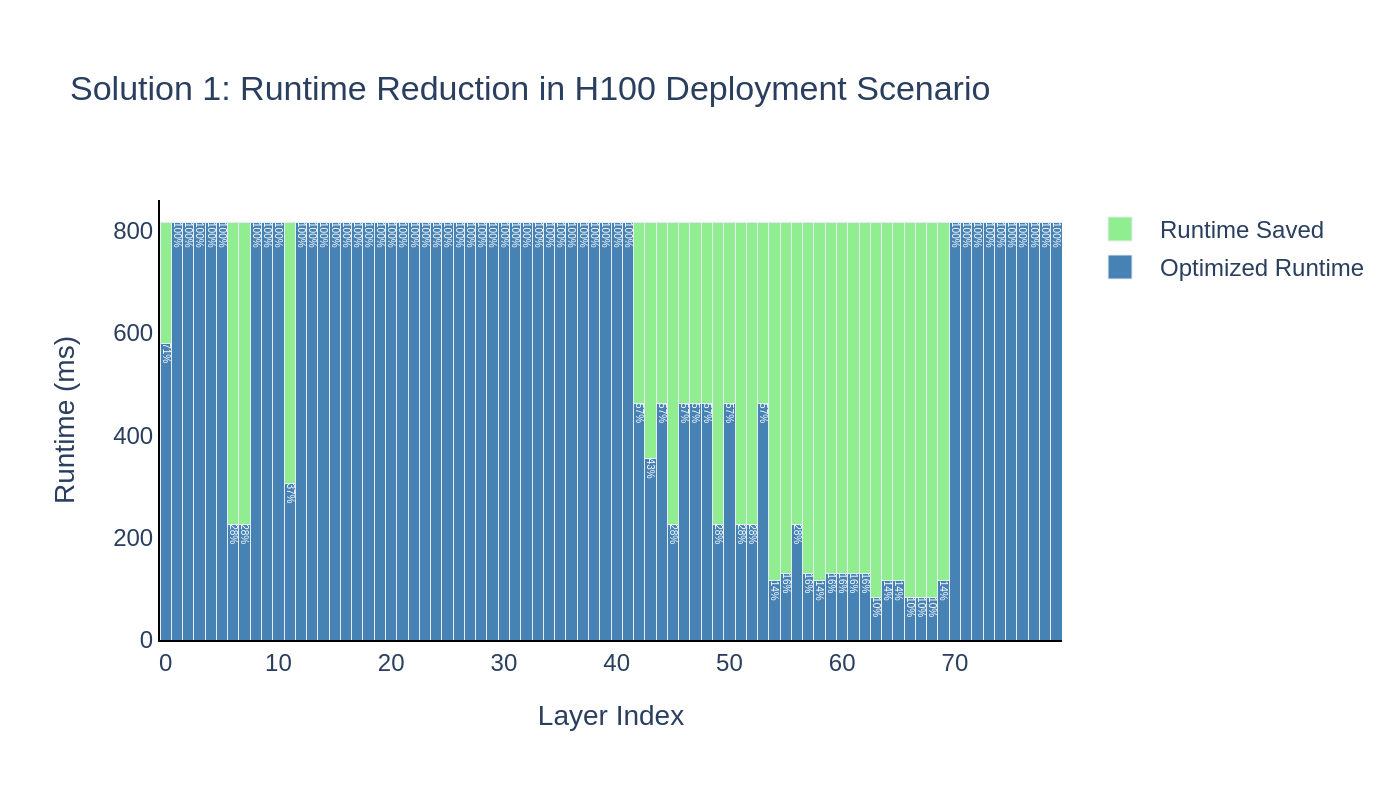


Runtime Summary:
- Parent model runtime: 65357.8 ms
- Optimized runtime: 46980.2 ms
- Total speedup: 1.39x
- Average runtime reduction per layer: 28.1%
- Sum KL divergence: 6.8615


In [4]:
df1 = visualize_runtime_reduction(solution1, block_library, parent_block_stats, 
                                  "Solution 1: Runtime Reduction in H100 Deployment Scenario")


## Example 2: Edge Deployment with Strict Memory Constraints

For edge deployment scenarios (e.g., consumer GPUs), memory is often the primary constraint.
This example shows optimization with more aggressive memory reduction (fitting the model into 40GB) without a runtime constraint.


In [5]:
# Example: Edge deployment with strict memory constraints
# Optimize for deployment on edge devices with limited memory

# Much tighter memory constraint for edge devices
edge_memory_constraint = 40_000  # MiB (simulating a smaller GPU)

print("Running MIP optimization for edge deployment...")
print(f"Memory constraint: {edge_memory_constraint:,} MiB (aggressive reduction)")

constraints_edge = {
    "stats.memory_mib": edge_memory_constraint,
    "stats.runtime_ms": float("inf"),
}

chosen_block_variants_edge, total_value_edge, total_costs_edge = mip_nas(
    block_library=block_library,
    objective=objective,
    constraints=constraints_edge,
    bigger_is_better=bigger_is_better,
    max_seconds_per_solution=30.0)

print(f"\nOptimization Results:")
display_solution_stats(total_value_edge, total_costs_edge, 
                       block_library, parent_block_stats, measurement_info)

solution2 = {
    "chosen_block_variants": chosen_block_variants_edge,
    "total_value": total_value_edge,
    "total_costs": total_costs_edge,
    "constraints": constraints_edge,
    "name": "Edge Optimized"
}

Running MIP optimization for edge deployment...
Memory constraint: 40,000 MiB (aggressive reduction)

Optimization Results:
Solution Statistics:
  - Sum of blockwise KL divergence: 18.935023
  - Memory usage: 39998.9 MiB
  - Runtime: 25166.2 ms
  - Throughput: 12,207 tokens/second

Compared to Parent Model:
  - Memory: 34.8% of parent
  - Runtime: 38.5% of parent (neglecting the fact that the parent doesn't even fit on the GPU in this batch size)
  - Speedup: at least 2.60x
  - Throughput increase: at least +159.7%


### Comparison of Solutions for Different Deployment Scenarios

Let's compare all deployment scenarios to understand the trade-offs:

The comparison visualizes:
- **Runtime/Memory per Layer**: How each solution's layers perform relative to the parent model (100% = parent performance).
- **KL Divergence Across Layers**: Distribution of kl divergence loss across all 80 layers for each solution (lower is better).
- **Throughput**: Overall inference speed in tokens/second for each solution.

Comprehensive Solution Comparison
 Configuration  Memory (GB)  Runtime (s)  Throughput (tok/s)  Speedup  Sum KL Divergence
H100 Optimized         78.1        46.98              6539.0     1.39           6.861455
Edge Optimized         39.1        25.17             12207.0     2.60          18.935023

Visual Comparison:


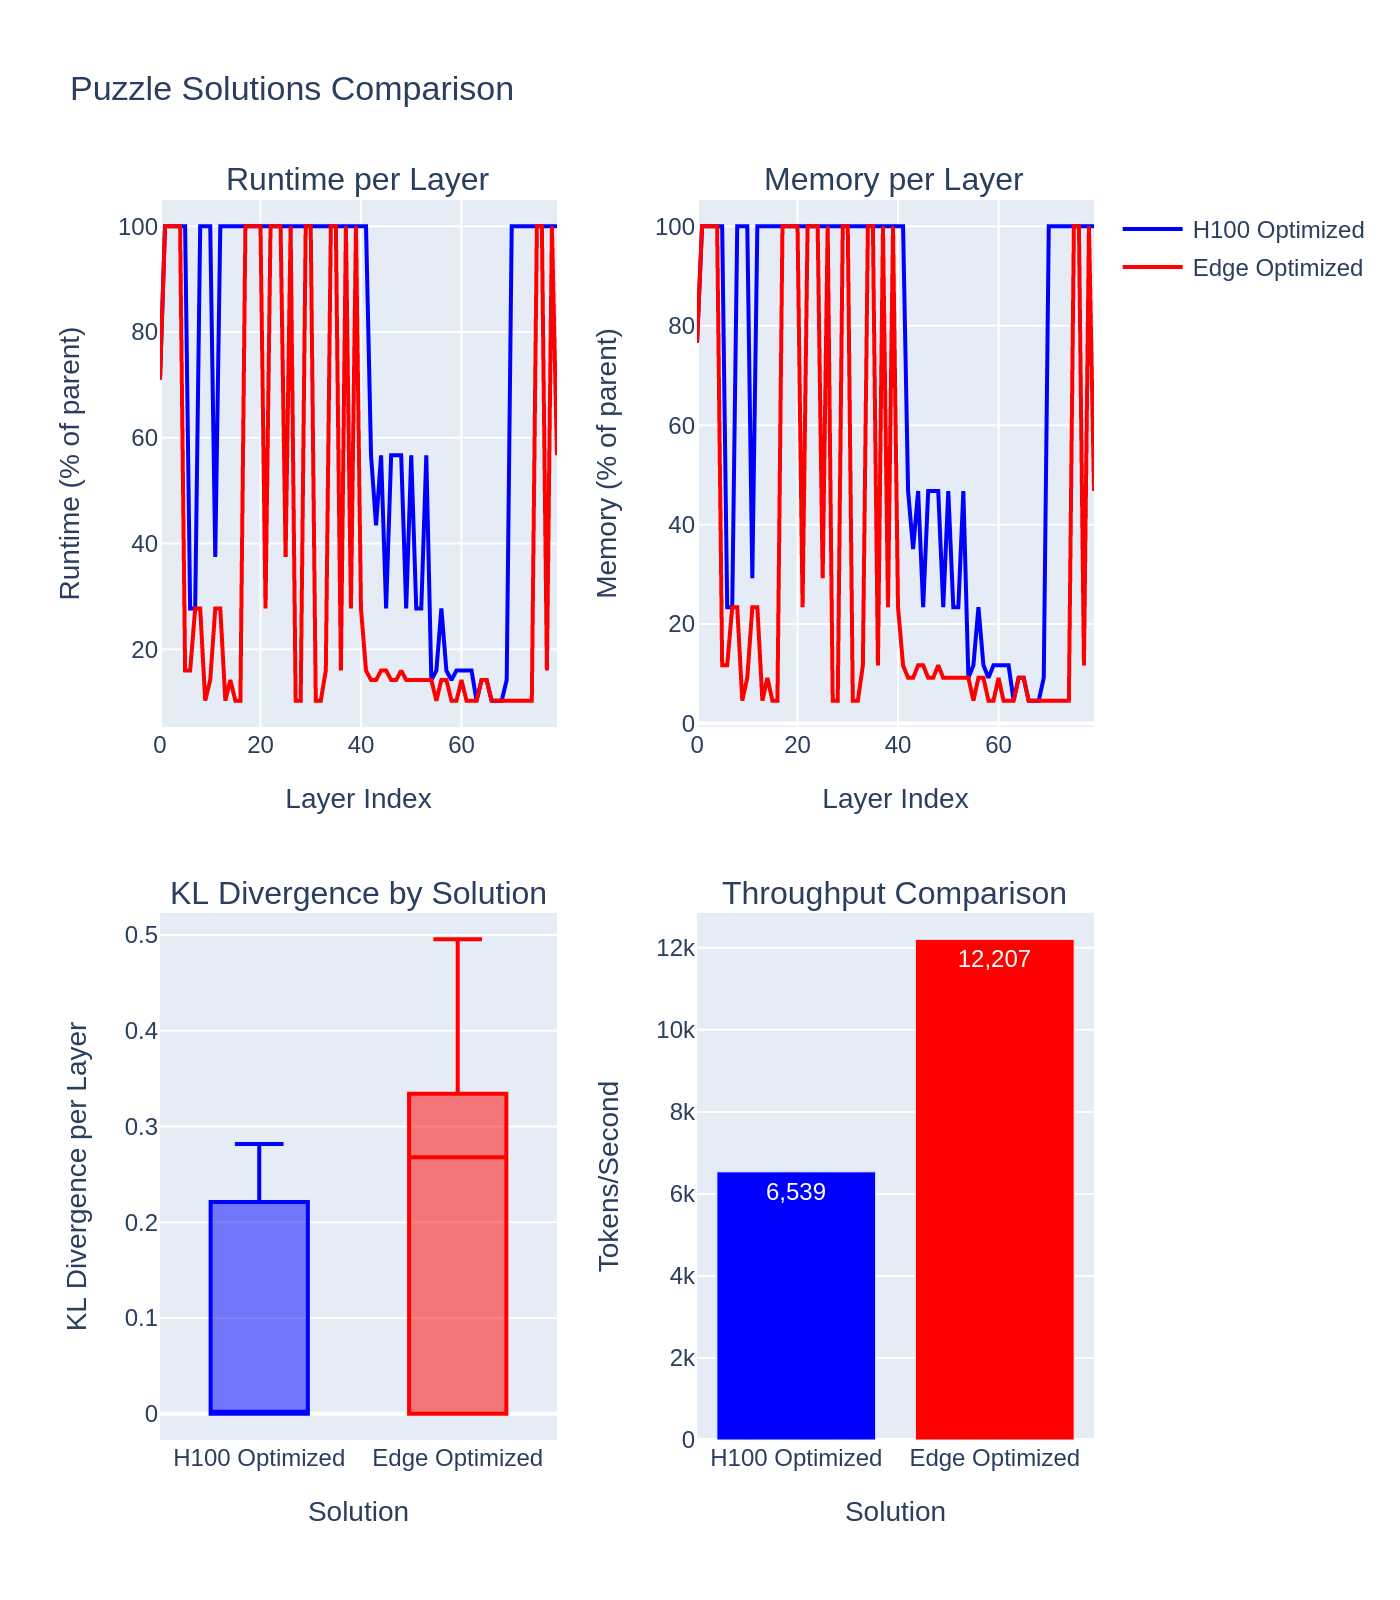

In [6]:

all_solutions = [solution1, solution2]
comprehensive_solution_comparison(all_solutions, block_library, parent_block_stats, measurement_info)


## Example 3: Multiple Solutions with Diversity Constraints

The MIP solver can generate multiple diverse solutions, useful for testing several promising architectures instead of one. Since the MIP's objective is only an estimation of real performance (sum of KL divergence scores).

The `minimal_diversity` parameter ensures solutions differ in at least N layers:


In [7]:
# Example: Generate multiple diverse solutions
# Calculate constraints based on the actual parent model stats
num_layers = len(block_library)
parent_memory_per_layer = parent_block_stats['stats']['memory_mib']
parent_runtime_per_layer = parent_block_stats['stats']['runtime_ms']

constraints_multi = {
    "stats.memory_mib": num_layers * parent_memory_per_layer * 0.85,
    "stats.runtime_ms": num_layers * parent_runtime_per_layer * 0.85,
}

minimal_diversity = 20 # Solutions must differ in at least 20 layers between solutions

print(f"Generating multiple diverse solutions with {minimal_diversity=} ...")
print(f"Number of layers: {num_layers}")
print(f"Constraints: Memory={constraints_multi['stats.memory_mib']:.0f} MiB (85% of parent total)")
print(f"           Runtime={constraints_multi['stats.runtime_ms']:.0f} ms (85% of parent total)")

multi_solutions = multi_solution_mip_nas(
    block_library=block_library,
    objective=objective,
    constraints=constraints_multi,
    bigger_is_better=bigger_is_better,
    num_solutions=3,
    minimal_diversity=minimal_diversity,
)

print(f"\nGenerated {len(multi_solutions)} solutions. Notice how the objective (Sum KL Divergence) monotonically gets worse.")
for i, sol in enumerate(multi_solutions):
    print(f"\nSolution {i+1}:")
    print(f"  - Sum KL Divergence: {sol['total_value']:.4f}")
    print(f"  - Memory: {sol['total_costs']['stats.memory_mib']:.1f} MiB")
    # Note: runtime_ms is the latency (forward pass time) in milliseconds\n
    print(f"  - Runtime: {sol['total_costs']['stats.runtime_ms']:.1f} ms")

# Check diversity between solutions
if len(multi_solutions) >= 2:
    sol1_configs = multi_solutions[0]['chosen_block_variants']
    sol2_configs = multi_solutions[1]['chosen_block_variants']
    differences = sum(1 for layer in sol1_configs if sol1_configs[layer] != sol2_configs[layer])
    print(f"\nDiversity check: Solutions 1 and 2 differ in {differences} layers")


Generating multiple diverse solutions with minimal_diversity=20 ...
Number of layers: 80
Constraints: Memory=97723 MiB (85% of parent total)
           Runtime=55554 ms (85% of parent total)


multi_solution_mip_nas: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Generated 3 solutions. Notice how the objective (Sum KL Divergence) monotonically gets worse.

Solution 1:
  - Sum KL Divergence: 3.2821
  - Memory: 96418.0 MiB
  - Runtime: 55547.9 ms

Solution 2:
  - Sum KL Divergence: 3.3417
  - Memory: 96607.1 MiB
  - Runtime: 55540.0 ms

Solution 3:
  - Sum KL Divergence: 3.3822
  - Memory: 96238.0 MiB
  - Runtime: 55552.8 ms

Diversity check: Solutions 1 and 2 differ in 20 layers


## Notes About the MIP Optimization

### 1. **Constraint Trade-offs**
- Tighter resource constraints (e.g., less memory, faster runtime) may cause the accuracy to degrade more,
  since lighter block variants would need to be used.
- The MIP solver tries to find the model with the best objective score given your constraints.

### 2. **Layer-wise Optimization**
- The solver can choose different configurations for each layer independently.
- The above visualizations show how reduction varies across layers. You can create your own solutions for your specific constraints and see how results differ.

### 3. **Scalability**
- With 80 layers × 16 configurations = 1280 binary indicator variables.
- Total search space: 16^80 ~= 2e96 possible architectures.
- The MIP solver efficiently navigates this space, finding a solution in seconds.

### 4. **Block Scores and the MIP's Objective**
- Remember that MIP optimizes for the block scores provided (sum of blocks' KL Divergence scores). If resources allow, consider evaluating the MIP's top-k solutions.
- If a specific downstream task is required for the optimized LLM, consider collecting block scores on data from this task (refer to the paper to learn more).

### 5. **How MIP fits inside the Puzzle pipeline**
- In a complete Puzzle pipeline:
  - **Before the MIP stage**: We run BLD and evaluate all alternative blocks to create the block library.
  - **After the MIP stage**: We use GKD to fine-tune the assembled architecture.


### References:
- [Puzzle Paper (ICML 2025)](https://openreview.net/pdf?id=RY5MMBHRqo)
- [ICML 2025 Presentation](https://icml.cc/virtual/2025/poster/45275)
- [Video Summary](https://www.youtube.com/watch?v=YsIv9Kr99C4)